In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path.
import branchingdnn as branching

In [2]:
# (train_ds, test_ds, validation_ds) = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(227,227),include_targets=True)

In [3]:
def calcEntropy(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        if isinstance(y_hat, list):
            y_hat = np.array(y_hat)
        sum_entropy = 0
        if y_hat.ndim >1:
            return list(map(calcEntropy,y_hat))
        for i in range(len(y_hat)):
            if y_hat[i] != 0: # log of zero is undefined, see MacKay's book "Information Theory, Inference, and Learning Algorithms"  for more info on this workaround reasoning.
                entropy =y_hat[i] * math.log(y_hat[i],2)
                sum_entropy +=  entropy

        return -sum_entropy
    
def calcEntropy_Tensors(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        #doesn't deal with cases of log(0)
        rank = tf.rank(y_hat)
        def calc_E(y_hat):
            results = tf.clip_by_value((tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))), -1e12, 1e12)
#             results = tf.clip_by_value(results, -1e12, 1e12)
#             print("res ", results)
            return tf.reduce_sum(y_hat * results)

        sumEntropies = (tf.map_fn(calc_E,tf.cast(y_hat,'float')))
        
        if rank == 1:
            sumEntropies = tf.reduce_sum(sumEntropies)
        return -sumEntropies
    
def calcEntropy_Tensors2(y_hat):
    #entropy is the sum of y * log(y) for all possible labels.
    #doesn't deal with cases of log(0)
#     num = tf.math.log(y_hat)
# #     print("num",num)
#     dem = tf.math.log(tf.constant(2, dtype=y_hat.dtype))
# #     print("dem",dem)
#     E = num / dem
# #     print("E",E)
#     P = y_hat * E
# #     print("p",P)
#     mean = tf.reduce_mean(tf.boolean_mask(P, tf.math.is_finite(P)))
#     print("mean",mean)
#     sumEntropies = mean
    val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
    sumEntropies =  tf.reduce_mean(tf.boolean_mask(val,tf.math.is_finite(val)))
    return -sumEntropies
    
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)

    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)

    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

In [4]:
class CrossEntropyEndpoint(tf.keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(CrossEntropyEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
#             self.kl = tf.keras.losses.KLDivergence()
            self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
#             self.loss_fn = tf.keras.losses.categorical_crossentropy
            self.evidence = softplus_evidence
#             self.evidence = tf.compat.v1.distributions.Dirichlet
            self.temperature = 10
            self.lmb = 0.005
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels,learning_rate=1):
            outputs = tf.matmul(inputs,self.kernel)
            softmax = tf.nn.softmax(outputs)
            evidence = self.evidence (outputs)
            alpha = evidence + 1
            u = self.num_outputs / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
          
            # prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
            pred = tf.argmax(outputs,1)
            truth = tf.argmax(labels,1)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
            # total_evidence = tf.reduce_sum(evidence,1, keepdims=True)
            mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )
            
            self.add_metric(evidence, name=self.name+"_evidence",aggregation='mean')
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ",aggregation='mean')
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail",aggregation='mean')
            
            return outputs

In [5]:
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay

    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C

    return  cross_entropy_evidence

In [6]:
K = 10
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence

# outputs =[]
# targets = tf.keras.Input(shape=(10,),name='targets')
# inputs = tf.keras.Input(shape=(227,227,3))
# x = tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)


# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)
# # branch_output_1 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))
# branch_output_1 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)

# x = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)


# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)
# # branch_output_2 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))
# branch_output_2 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)

# x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(4096, activation='relu')(x)



# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)
# branch_output_3 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)
# # branch_output_3 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))

# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(4096, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# output = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("endpoint"))(x)
# # output = CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("endpoint"))(x, targets)

# model = tf.keras.Model(inputs=[inputs,targets], outputs=[output,branch_output_1,branch_output_2,branch_output_3], name="alexnet_branched_entropy")
# loss_fn = loss_function()
# model.compile( loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])



In [7]:
# import time
# root_logdir = os.path.join(os.curdir, "logs\\fit\\")
# checkpoint = tf.keras.callbacks.ModelCheckpoint("alexNetv6_entropy_branched_scratch_40.hdf5", monitor='val_loss',verbose=1,save_best_only=True, mode='auto')
# def get_run_logdir():
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)

# run_logdir = get_run_logdir()
# tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
# model.fit(train_ds,
#         epochs=40,
#         validation_data=validation_ds,
#         validation_freq=1,
#         # batch_size=1,
#         verbose=1,
#         callbacks=[tensorboard_cb,checkpoint])

In [8]:
dataset = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(224,224), include_targets=True)


augment Dataset
targetsis : True
adding targets to inputs
trainSize 45000
testSize 10000


In [51]:
# (train_ds, validation_ds, test_ds) = dataset
# print(train_ds.take(1))

In [9]:
# model  = tf.keras.models.load_model('alexNetv6_evidence_branched_contin_30.hdf5', custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"cross_entropy_evidence":loss_function()})

loss_fn = loss_function()
brevis = (branching.core.branched_model(modelName="../models/resnet50_finetuned.hdf5",saveName="resNet50_entropy_conv2d",transfer=True,customOptions="")
            .add_branches(branching.branches.branch.branch_conv2d_entropy,["conv2_block1_out","conv2_block3_out","conv3_block4_out"], target_input=True)
            .set_dataset(dataset)
            
            )
# brevis.evaluate(test_ds)


targets already present?  False
added targets
Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
add Branch to branch point  conv2_block3_out
add Branch to branch point  conv3_block4_out


In [10]:
brevis.model.summary()

Model: "model_branched"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________________________________________________________________

branch_softmax_2 (Softmax)      (None, 10)           0           branch10_2[0][0]                 
Total params: 28,453,480
Trainable params: 28,400,360
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [11]:
model = brevis.trainTransfer(12, loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(), transfer=True, customOptions="")

Freezing Main Layers and setting branch layers training to true

customOption: Other
https://app.neptune.ai/cailen01/branchingDNN/e/BRAN-372
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/12
1063/1406 [=====================>........] - ETA: 2:00 - loss: 18.9530 - classification_loss: 0.0230 - branch_softmax_loss: 2.4093 - branch_softmax_1_loss: 14.2438 - branch_softmax_2_loss: 2.2769 - classification_accuracy: 0.9931 - branch_softmax_accuracy: 0.1038 - branch_softmax_1_accuracy: 0.0993 - branch_softmax_2_accuracy: 0.1404

KeyboardInterrupt: 

In [54]:
model  = tf.keras.models.load_model('models/resNet50_entropy_conv2d.hdf5', custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"cross_entropy_evidence":loss_function()})

In [67]:
def collectEvidence_branches(model,test_ds, evidence=True):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    pOverlap=[]

    Outputs = pd.DataFrame()
    pAcc=[]
    for i in range(num_outputs):
        pClass.append([])
        predictions.append([])
        pEvidence.append([])
        pUncertainty.append([])
        pAcc.append([])
        pOverlap.append([])
        # pOutputs.append([])

    for i, (x,y) in enumerate(test_ds):
        # if i > 10:
            # break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        if evidence: 
            result = model.test_on_batch(x,y)
#             print(result)
            for j in range(num_outputs):
#                 print("output",j)
                pClass[j].append(tf.argmax(y[0]).numpy())
#                 print("class",pClass[j][i])
                pAcc[j].append(result[j+(num_outputs+1)])  
#                 print("acc",pAcc[j][i])
                if j ==0:
                    pEvidence[j].append(0)
                else:
#                     print("evid Number",((num_outputs * 2)+1), " ", ((j-1)*3))
                    pEvidence[j].append(result[((num_outputs * 2) + 1)+((j-1)*3)])
#                 print("evid",pEvidence[j][i])

                pOverlap[j].append(pAcc[0][i] - pAcc[j][i])
#                 print("overlap",pOverlap[j][i])
        else:
            result = model.predict(x)[0]
            print(result)

            for j in range(num_outputs):
                pClass[j].append(tf.argmax(y[0]).numpy())
                # print(pClass[j])
                # print(result)
                prediction = np.argmax(result[j])
                if prediction == pClass[j][i]:
                    pAcc[j].append(1)  
                else:
                    pAcc[j].append(0)  
                # print(branching.utils.calcEntropy_Tensors(result[j]).numpy())
                pEvidence[j].append(branching.utils.calcEntropy_Tensors(result[j]).numpy()[0])

                pOverlap[j].append(pAcc[0][i] - pAcc[j][i])
        '''
        overlap
        if zero, both match, if else they don't match
        TT 1-1 =0
        TF 1-0 =1

        FT 0-1 = -1
        FF 0-0 =0
        
        '''
    Outputs=[]
    for j in range(num_outputs):
        Predictions = pd.DataFrame({"label":pClass[j],"evidence":pEvidence[j],"Acc":pAcc[j], "overlap":pOverlap[j]})
        Outputs.append(Predictions)
    return Outputs

def displayEvidence(branch_predictions, output_names=["main_exit","branch_1","branch_2","branch_3"], Evidence = True):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    series=[]
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    Outputs=pd.DataFrame()
    for i, Predictions in enumerate(branch_predictions):
        Predictions["Acc"]=Predictions["Acc"].astype('bool') ##sometime the predictions can come back with 0.5 acc, this should be rounded to 1.
        # Predictions["evidence"]=Predictions["evidence"].()[0]
        acc = Predictions["Acc"].value_counts()
        # print(acc)
        # print((acc.loc[True] , acc.loc[False]))
        mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
        std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
        
        correct_rows = Predictions.loc[Predictions['Acc'] == True]
        incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
        if Evidence:
            E_threshold = mean + std
            Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
            Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                    "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                    "E_Threshold":E_threshold,
                    # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                    "acceptance_rate":Predictions.loc[(Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                    "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                    "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                    "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "Incorrects_overlap":Incorrects_overlap,
                    },index=[i]))
        else:
            print("mean",mean , " std",std)
            E_threshold = mean - std
            Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
            # if i ==1 or i == 0 :
                # print(Predictions)
                # print(Predictions.loc[ (Predictions['Acc'] == True)  & (Predictions["overlap"] == 0) ])
            # print(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold) ].count())
            Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                    "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                    "E_Threshold":E_threshold,
                    # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                    "acceptance_rate":Predictions.loc[(Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                    "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                    "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                    "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "Incorrects_overlap":Incorrects_overlap,
                    },index=[i]))
        axs[round(int(i/2)), round(i%2)]
    # fig, axs = plt.subplots(1, 2)
        # axs[round(int(i/2)), round(i%2)].suptitle('Horizontally stacked subplots')
        axs[round(int(i/2)), round(i%2)].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
        axs[round(int(i/2)), round(i%2)].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
        axs[round(int(i/2)), round(i%2)].plot(np.repeat(E_threshold,11),'b--')
        axs[round(int(i/2)), round(i%2)].title.set_text("evidence")
    
    for ax in fig.axes:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axLine, axLabel = ax.get_legend_handles_labels()
            lines=(axLine)
            labels=(axLabel)
    fig.text(0.5, 0.01, 'Items Exit at Branch', ha='center', va='center')
    fig.text(0.01, 0.5, 'Accuracy %', ha='center', va='center', rotation='vertical')
    # fig.legend(lines, labels,bbox_to_anchor=(1., 1), loc=2,borderaxespad=0.,frameon=True)
    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs


def evidenceHistogram(branch_predictions, output_names=["main_exit","branch_1","branch_2","branch_3"], Evidence = True):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    series=[]
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    Outputs=pd.DataFrame()
    for i, Predictions in enumerate(branch_predictions):
        Predictions["Acc"]=Predictions["Acc"].astype('bool')
        # Predictions["evidence"]=Predictions["evidence"].()[0]
        acc = Predictions["Acc"].value_counts()
        # print(acc)
        # print((acc.loc[True] , acc.loc[False]))
        mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
        std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
        
        correct_rows = Predictions.loc[Predictions['Acc'] == True]
        incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
        if Evidence:
            # E_threshold = mean + std + einsumfunc

            Accepted = Predictions.loc[(Predictions["evidence"] <= E_threshold)]
            Rejected = Predictions.loc[(Predictions["evidence"] > E_threshold)]
            Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
            Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                    "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                    "E_Threshold":E_threshold,
                    # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                    "acceptance_rate":Predictions.loc[(Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                    "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                    "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                    "T_F":Accepted.loc[Accepted['overlap']==1],
                    "F_T":Accepted.loc[Accepted['overlap']==-1],
                    "Incorrects_overlap":Incorrects_overlap,
                    },index=[i]))
        else:
            print("mean",mean , " std",std)
            E_threshold = mean - std
            Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
            # if i ==1 or i == 0 :
                # print(Predictions)
                # print(Predictions.loc[ (Predictions['Acc'] == True)  & (Predictions["overlap"] == 0) ])
            # print(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold) ].count())
           
            Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                    "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                    "E_Threshold":E_threshold,
                    # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                    "acceptance_rate":Predictions.loc[(Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                    "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                    "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                    "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "Incorrects_overlap":Incorrects_overlap,
                    },index=[i]))
        axs[round(int(i/2)), round(i%2)]
    # fig, axs = plt.subplots(1, 2)
        # axs[round(int(i/2)), round(i%2)].suptitle('Horizontally stacked subplots')
        axs[round(int(i/2)), round(i%2)].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
        axs[round(int(i/2)), round(i%2)].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
        axs[round(int(i/2)), round(i%2)].plot(np.repeat(E_threshold,11),'b--')
        axs[round(int(i/2)), round(i%2)].title.set_text("evidence")
    
    for ax in fig.axes:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axLine, axLabel = ax.get_legend_handles_labels()
            lines=(axLine)
            labels=(axLabel)
    fig.text(0.5, 0.01, 'Items Exit at Branch', ha='center', va='center')
    fig.text(0.01, 0.5, 'Accuracy %', ha='center', va='center', rotation='vertical')
    # fig.legend(lines, labels,bbox_to_anchor=(1., 1), loc=2,borderaxespad=0.,frameon=True)
    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs

def displayEvidence_cascade(branch_predictions, thresholds=None, output_names=["branch_1","branch_2","branch_3","Main_Exit"], Evidence = True):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    series=[]
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    Outputs=pd.DataFrame()
    #lets reorder the predictions so that the final layer is at the end
    # _branch_predictions.copy()
    _branch_predictions = branch_predictions.copy()
    # print(_branch_predictions)
    _branch_predictions.append(_branch_predictions.pop(0))
    # print(_branch_predictions)
    rollOver_indices = pd.Index([])
    for i, Predictions in enumerate(_branch_predictions):
        #check if rollover is active, if so, select only the predictions whose indexes match the rollover list
        # print(rollOver_indices)
        test_acc = Predictions["Acc"].astype('bool').value_counts()
        test_accuracy = (test_acc.loc[True] /  (test_acc.loc[True] + test_acc.loc[False]))
        if len(rollOver_indices)>0:
            print("rollover enabled, {} predictions provided".format(len(rollOver_indices)))
            Predictions = Predictions.iloc[rollOver_indices]
        # print(Predictions.shape)
        Predictions["Acc"]=Predictions["Acc"].astype('bool')
        # Predictions["evidence"]=Predictions["evidence"].()[0]
        acc = Predictions["Acc"].value_counts()
        # print(acc)
        # print((acc.loc[True] , acc.loc[False]))
        _Incorrects_missed = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["overlap"] == 1)] #all the predictions that the main exit got true and the branch got wrong
        print("incorrects",_Incorrects_missed)
        if len(_Incorrects_missed) > 0 :
            print("incorrects",_Incorrects_missed)
            mean = _Incorrects_missed.groupby("Acc")["evidence"].mean().iloc[0]
            std = _Incorrects_missed.groupby("Acc")["evidence"].std().iloc[0]
        else:
            print("pred",Predictions.loc[(Predictions['Acc'] == False)])
            mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
            std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]

        print("mean",mean , " std",std)
        
        correct_rows = Predictions.loc[Predictions['Acc'] == True]
        incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
        
        E_threshold = -1 #-1 is null for threshold
        if thresholds is not None:
            try:
                E_threshold = thresholds[i]
            except:
                print("threshold not supplied for branch {}, using test data".format(i))
                
        if Evidence:
            if E_threshold ==-1:
                E_threshold = mean + std
            Accepted = Predictions.loc[(Predictions["evidence"] >= E_threshold)]
            Rejected = Predictions.loc[(Predictions["evidence"] < E_threshold)]
        else: 
            if E_threshold ==-1:
                E_threshold = mean - std
            Accepted = Predictions.loc[(Predictions["evidence"] <= E_threshold)]
            Rejected = Predictions.loc[(Predictions["evidence"] > E_threshold)]
        
        rollOver_indices = Rejected.index
        Incorrects_overlap = Accepted.loc[(Accepted['Acc'] == False) & (Accepted["overlap"] == 0)].count().iloc[0]
        print(Accepted.shape[0])
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                "Predictions": len(Predictions.index),
                "test_accuracy": test_accuracy,
                "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Accepted.shape[0]/(Predictions.shape[0]),
                "accepted_correct":Accepted.loc[(Predictions['Acc'] == True)].shape[0],
                "accepted_incorrect":Accepted.loc[(Predictions['Acc'] == False)].shape[0],
                "accepted_accuracy":(Accepted.loc[(Accepted['Acc'] == True)].shape[0])/ Accepted.shape[0],
                "overlap_adjusted_accuracy":(Accepted.loc[(Accepted['Acc'] == True)].count()[0] + Incorrects_overlap) / Accepted.count()[0],
                "M(T) B(F)":Accepted.loc[(Accepted["overlap"] == 1)].count().iloc[0],
                "M(F) B(T)":Accepted.loc[(Accepted["overlap"] ==-1)].count().iloc[0],
                "M(F) B(F) overlap":Incorrects_overlap,
                },index=[i]))
#         print("TT",Accepted.loc[(Accepted["Acc"] ==True) & (Accepted["overlap"] == 0)])
#         print("TF",Accepted.loc[(Accepted["overlap"] == 1)])
#         print("FT",Accepted.loc[(Accepted["overlap"] == -1)])
#         print("FF",Accepted.loc[(Accepted["Acc"] ==False) & (Accepted["overlap"] == 0)])
        axs[round(int(i/2)), round(i%2)]
    # fig, axs = plt.subplots(1, 2)
        # axs[round(int(i/2)), round(i%2)].suptitle('Horizontally stacked subplots')
        axs[round(int(i/2)), round(i%2)].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
        axs[round(int(i/2)), round(i%2)].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
        axs[round(int(i/2)), round(i%2)].plot(np.repeat(E_threshold,11),'b--')
        axs[round(int(i/2)), round(i%2)].title.set_text(output_names[i])
    
    for ax in fig.axes:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axLine, axLabel = ax.get_legend_handles_labels()
            lines=(axLine)
            labels=(axLabel)
    fig.text(0.5, 0.01, 'Items Exit at Branch', ha='center', va='center')
    fig.text(0.01, 0.5, 'Accuracy %', ha='center', va='center', rotation='vertical')
    # fig.legend(lines, labels,bbox_to_anchor=(1., 1), loc=2,borderaxespad=0.,frameon=True)
    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs

In [68]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
K= 10 # number of classes
test_labels = tf.keras.utils.to_categorical(test_labels,10)
train_labels = tf.keras.utils.to_categorical(train_labels,10)
shuffle_size = 22500
batch_size=1
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
def augment_images(image, label,input_size=(224,224), channel_first = False):
            image = tf.image.resize(image,input_size)
            if channel_first:
                image = tf.transpose(image, [2, 0, 1])
            return image, label
test_ds_size = len(list(test_ds))
test_ds = (test_ds.map(augment_images))
t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))
test_ds = (test_ds.batch(batch_size=1, drop_remainder=True))

validation_size = 5000
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
shuffle_size = 22500
batch_size=1
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
validation_ds_size = len(list(validation_ds))
validation_ds = (validation_ds.map(augment_images))
v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
validation_ds = tf.data.Dataset.zip((validation_ds,v_target))
validation_ds = (validation_ds.batch(batch_size=1, drop_remainder=True))

In [69]:

# Predictions = collectEvidence_branches(model,test_ds)
validation_Outputs = collectEvidence_branches(model,validation_ds, False)
test_Outputs = collectEvidence_branches(model,test_ds, False)
# print(Outputs)

outputs 4
[array([[4.5908990e-08, 9.3287565e-07, 3.4941577e-06, 2.0462116e-05,
        3.7509692e-06, 1.6743077e-05, 9.9995387e-01, 5.3604936e-07,
        9.7465744e-08, 1.1627315e-07]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[5.5644031e-28, 6.7391467e-28, 5.5644031e-28, 1.0000000e+00,
        5.5644031e-28, 5.5644031e-28, 5.5644031e-28, 5.5644031e-28,
        5.5644031e-28, 5.5644031e-28]], dtype=float32), array([[9.2500901e-05, 9.2500901e-05, 1.6071550e-03, 9.2500901e-05,
        9.2500901e-05, 1.7074717e-04, 8.1754470e-01, 1.8012246e-01,
        9.2500901e-05, 9.2500901e-05]], dtype=float32)]
[array([[1.1903631e-09, 1.0893695e-09, 3.9493050e-10, 3.8216041e-10,
        6.0500362e-11, 2.8609191e-09, 1.4719664e-10, 2.5792373e-09,
        8.3561229e-09, 1.0000000e+00]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[5.396283e-31, 5.396283e-31, 5.396283e-31, 1.000000e+00,
    

[array([[1.2359166e-06, 1.2031994e-06, 1.0154081e-07, 5.3731306e-08,
        1.3525695e-09, 1.4058013e-08, 2.3069248e-08, 2.1829270e-09,
        8.3897064e-08, 9.9999726e-01]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[5.902927e-29, 6.726353e-29, 5.902927e-29, 1.000000e+00,
        5.902927e-29, 5.902927e-29, 5.902927e-29, 5.902927e-29,
        5.902927e-29, 5.902927e-29]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32)]
[array([[2.0947717e-05, 4.2923858e-08, 2.0802279e-08, 4.9561539e-08,
        7.1835199e-10, 2.0787246e-08, 2.2748374e-09, 8.5831781e-10,
        1.3510187e-06, 9.9997759e-01]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[1.4880614e-34, 1.4880614e-34, 1.4880614e-34, 1.0000000e+00,
        1.4880614e-34, 1.4880614e-34, 2.0946639e-34, 1.4880614e-34,
        1.4880614e-34, 1.4880614e-34]], dtype=float32), array([[0.1,

      dtype=float32)]
[array([[9.9999881e-01, 1.5648837e-08, 5.1176958e-08, 1.2623065e-09,
        8.2846082e-12, 1.2438586e-08, 1.8648522e-10, 1.7871218e-09,
        2.6945520e-07, 8.6476746e-07]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[1.0042706e-29, 1.2182029e-29, 1.0042706e-29, 1.0000000e+00,
        1.0042706e-29, 1.0042706e-29, 1.0042706e-29, 1.0042706e-29,
        1.0042706e-29, 1.0042706e-29]], dtype=float32), array([[9.9563390e-01, 1.0679055e-04, 4.2266729e-03, 4.6465270e-06,
        4.6465270e-06, 4.6465270e-06, 4.6465270e-06, 4.6465270e-06,
        4.6465270e-06, 4.6465270e-06]], dtype=float32)]
[array([[5.6469900e-09, 3.3057887e-08, 7.9449318e-09, 1.0437801e-06,
        2.2191665e-10, 3.2151044e-07, 7.7132816e-09, 1.8551789e-08,
        2.0282476e-09, 9.9999857e-01]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[7.3023825e-31, 7.3023825e-31, 7.3023825e-31, 1.0

        4.4541827e-14, 4.4541827e-14]], dtype=float32)]
[array([[5.2557763e-08, 9.9999762e-01, 6.8053083e-08, 1.5852232e-08,
        2.8848095e-08, 3.4501245e-08, 1.8397031e-06, 6.0367057e-08,
        1.9640592e-07, 2.0314185e-07]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[6.2305760e-28, 7.9514156e-28, 6.2305760e-28, 1.0000000e+00,
        6.2305760e-28, 6.2305760e-28, 6.2305760e-28, 6.2305760e-28,
        6.2305760e-28, 6.2305760e-28]], dtype=float32), array([[0.00132889, 0.98804003, 0.00132889, 0.00132889, 0.00132889,
        0.00132889, 0.00132889, 0.00132889, 0.00132889, 0.00132889]],
      dtype=float32)]
[array([[5.0800099e-07, 9.9998009e-01, 1.1745227e-06, 4.3285345e-06,
        1.7637181e-07, 1.2418099e-06, 2.9411456e-06, 2.2580210e-07,
        5.0512681e-06, 4.3734599e-06]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[1.4740465e-31, 1.4740465e-31, 1.4740465e-31, 1

        2.5856411e-07, 2.5856411e-07]], dtype=float32)]
[array([[1.6392512e-07, 3.2962060e-08, 2.7644567e-03, 2.4663980e-06,
        9.9667573e-01, 4.1552175e-05, 2.1392482e-06, 5.1293726e-04,
        9.1758920e-08, 3.3198367e-07]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[6.685048e-27, 7.087425e-27, 6.685048e-27, 1.000000e+00,
        6.685048e-27, 6.685048e-27, 6.685048e-27, 6.685048e-27,
        6.685048e-27, 6.685048e-27]], dtype=float32), array([[7.4209529e-05, 7.4209529e-05, 4.9230641e-01, 8.3192624e-03,
        1.3414679e-01, 3.5526964e-01, 7.0064636e-03, 2.6546060e-03,
        7.4209529e-05, 7.4209529e-05]], dtype=float32)]
[array([[3.4810969e-06, 2.9136496e-07, 2.1339905e-05, 9.9362105e-01,
        3.0876092e-06, 5.9754895e-03, 4.2860401e-07, 7.5018434e-06,
        2.1861931e-07, 3.6707151e-04]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[5.830012e-31, 5.830012e-

        1.2384311e-28, 1.2384311e-28]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32)]
[array([[3.0278034e-05, 2.5568821e-04, 1.0293452e-03, 1.5114653e-03,
        9.1797956e-06, 2.7285767e-05, 9.9700648e-01, 5.1469611e-05,
        1.0888549e-05, 6.7914421e-05]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[9.262116e-31, 9.989401e-31, 9.262116e-31, 1.000000e+00,
        9.262116e-31, 9.262116e-31, 9.262116e-31, 9.262116e-31,
        9.262116e-31, 9.262116e-31]], dtype=float32), array([[9.8632445e-06, 4.0599429e-05, 9.8632445e-06, 9.8632445e-06,
        9.8632445e-06, 9.8632445e-06, 9.9988055e-01, 9.8632445e-06,
        9.8632445e-06, 9.8632445e-06]], dtype=float32)]
[array([[2.8255542e-06, 4.1772870e-07, 6.4671877e-07, 1.1636843e-04,
        4.5114953e-06, 3.7302532e-05, 1.0926626e-07, 9.9979204e-01,
        2.6491100e-06, 4.3153992e-05]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1,

[array([[1.2677285e-07, 7.6943763e-08, 1.8616727e-05, 4.3191250e-07,
        9.9941158e-01, 1.4168553e-06, 1.5765146e-07, 5.6664913e-04,
        4.1717424e-08, 8.2063485e-07]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[5.3709518e-27, 5.4774064e-27, 5.3709518e-27, 1.0000000e+00,
        5.3709518e-27, 5.3709518e-27, 5.3709518e-27, 5.3709518e-27,
        5.3709518e-27, 5.3709518e-27]], dtype=float32), array([[3.0582274e-08, 3.0582274e-08, 1.0888619e-06, 1.7429256e-03,
        9.9729878e-01, 3.7605653e-04, 3.0582274e-08, 5.8093277e-04,
        3.0582274e-08, 3.0582274e-08]], dtype=float32)]
[array([[8.4370131e-06, 3.1932075e-06, 2.4098103e-04, 1.4189428e-05,
        1.3155243e-01, 8.0343518e-05, 1.5671418e-05, 8.6807305e-01,
        1.6830005e-06, 1.0116018e-05]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[5.7357853e-27, 5.7357853e-27, 5.7357853e-27, 1.0000000e+00,
        5.

        2.2650675e-03, 4.5784583e-04]], dtype=float32)]
[array([[1.2551730e-08, 7.8455988e-09, 4.7884782e-07, 9.9995208e-01,
        3.8090757e-08, 4.6902711e-05, 1.2357022e-07, 1.6992050e-08,
        3.8324961e-07, 1.5753882e-08]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[5.9456654e-28, 5.9861981e-28, 5.9456654e-28, 1.0000000e+00,
        5.9456654e-28, 5.9456654e-28, 5.9456654e-28, 5.9456654e-28,
        5.9456654e-28, 5.9456654e-28]], dtype=float32), array([[3.8562994e-06, 1.9728668e-06, 9.3510840e-04, 9.9156779e-01,
        4.3484653e-04, 7.0354063e-03, 7.5903517e-06, 9.6055674e-06,
        1.9728668e-06, 1.9728668e-06]], dtype=float32)]
[array([[1.5617812e-07, 4.7237205e-05, 1.9705521e-07, 4.0635391e-07,
        8.9927026e-09, 1.6961984e-07, 6.5488415e-09, 6.3571598e-08,
        9.6220575e-08, 9.9995160e-01]], dtype=float32), array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32), array([[1.3648372e-30,

KeyboardInterrupt: 

In [64]:
print(validation_Outputs)

[      label      evidence  Acc  overlap
0         6  8.178018e-04    1        0
1         9  4.778927e-07    1        0
2         9  3.003209e-03    1        0
3         4  4.408719e-05    1        0
4         1  2.322544e-04    1        0
5         1  1.538819e-04    1        0
6         2  9.001660e-05    1        0
7         7  4.481128e-03    1        0
8         8  2.832097e-02    1        0
9         3  3.226964e-02    1        0
10        4  1.710186e-04    1        0
11        7  2.467700e-02    1        0
12        7  9.753109e-04    1        0
13        2  5.330268e-03    1        0
14        9  5.855551e-05    1        0
15        9  3.876885e-04    1        0
16        9  2.746115e-03    1        0
17        3  5.027437e-01    1        0
18        2  4.903892e-02    1        0
19        6  5.286654e-02    1        0
20        4  5.310588e-05    1        0
21        3  1.381844e-03    1        0
22        6  5.493863e-04    1        0
23        6  1.281563e-04    1        0

incorrects       label  evidence    Acc  overlap
0         6  3.321928  False        1
1         9  3.321928  False        1
2         9  3.321928  False        1
3         4  3.321928  False        1
4         1  3.321928  False        1
5         1  3.321928  False        1
6         2  3.321928  False        1
7         7  3.321928  False        1
8         8  3.321928  False        1
9         3  3.321928  False        1
10        4  3.321928  False        1
11        7  3.321928  False        1
12        7  3.321928  False        1
13        2  3.321928  False        1
14        9  3.321928  False        1
15        9  3.321928  False        1
16        9  3.321928  False        1
17        3  3.321928  False        1
18        2  3.321928  False        1
19        6  3.321928  False        1
20        4  3.321928  False        1
21        3  3.321928  False        1
22        6  3.321928  False        1
23        6  3.321928  False        1
24        2  3.321928  False        1
2

mean 2.3997557512428065e-24  std 1.5609217235808547e-23
0


ZeroDivisionError: division by zero

<Figure size 432x288 with 0 Axes>

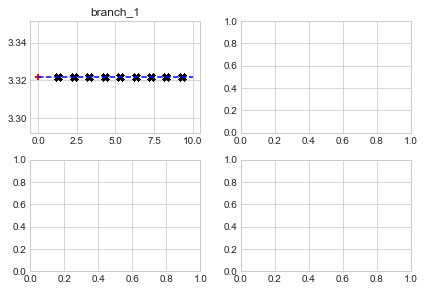

In [66]:
#### version 2
display(displayEvidence_cascade(validation_Outputs, Evidence = False))
display(displayEvidence_cascade(test_Outputs, Evidence = False))

mean 1.2688088593281048  std 0.7363923742269857
rollover enabled, 3688 predictions provided
mean 1.3331750000778075  std 0.580386591004303
rollover enabled, 2765 predictions provided
mean

c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 1.029322027654264  std 0.5453788187079066
rollover enabled, 1862 predictions provided
mean 0.9690331816673279  std 0.4958837655238281


<Figure size 432x288 with 0 Axes>

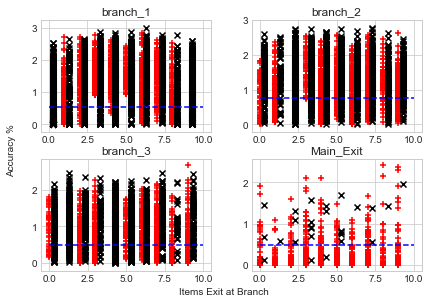

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,5000,0.3360,0.336000,0.532416,0.262400,609,703,0.464177,0.468750,697,11,6
1,branch_2,3688,0.4448,0.396421,0.752788,0.250271,521,402,0.564464,0.575298,392,5,10
2,branch_3,2765,0.4900,0.444485,0.483943,0.326582,589,314,0.652270,0.660022,307,6,7
3,Main_Exit,1862,0.9858,0.986037,0.473149,0.901182,1675,3,0.998212,1.000000,0,0,3


In [29]:
displayEvidence_cascade(validation_Outputs, Evidence = False)

mean 1.2534495413795237  std 0.738244331437056
rollover enabled, 7391 predictions provided
mean 1.3781813086694048  std 0.5711470427774136
rollover enabled, 5638 predictions provided


c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mean 1.0269744429013892  std 0.5484925768169612
rollover enabled, 3872 predictions provided
mean 0.9838146823900443  std 0.5560552143471937


<Figure size 432x288 with 0 Axes>

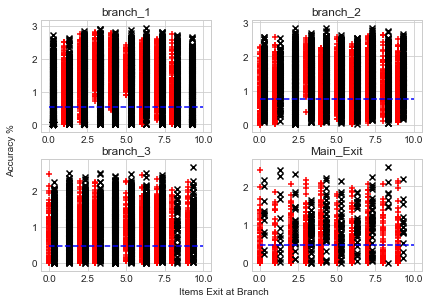

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,10000,0.3341,0.334100,0.532416,0.260900,1187,1422,0.454964,0.484477,1345,45,77
1,branch_2,7391,0.4365,0.384116,0.752788,0.237180,1049,704,0.598403,0.635482,639,20,65
2,branch_3,5638,0.4743,0.433842,0.483943,0.313232,1121,645,0.634768,0.676670,571,28,74
3,Main_Exit,3872,0.9427,0.931818,0.473149,0.815857,3111,48,0.984805,1.000000,0,0,48


In [30]:
displayEvidence_cascade(test_Outputs, thresholds=[0.532416,0.752788,0.483943,0.473149] ,Evidence = False)

mean 2.3775139060157775  std 0.44754977834901194
rollover enabled, 7356 predictions provided
mean 2.2910808496759185  std 0.4174707782345464
rollover enabled, 5637 predictions provided


c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mean 1.9400157221468561  std 0.44062205012064976
rollover enabled, 3731 predictions provided
mean 1.0032464265583023  std 0.582510151908757


<Figure size 432x288 with 0 Axes>

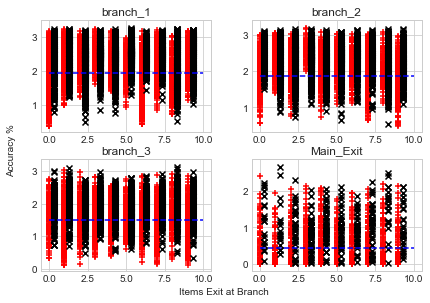

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,10000,0.4424,0.442400,1.929964,0.264400,1745,899,0.659985,0.686838,828,32,71
1,branch_2,7356,0.4920,0.423192,1.873610,0.233687,1029,690,0.598604,0.630017,636,27,54
2,branch_3,5637,0.6350,0.558453,1.499394,0.338123,1488,418,0.780693,0.808499,365,26,53
3,Main_Exit,3731,0.9427,0.916912,0.420736,0.776199,2840,56,0.980663,1.000000,0,0,56


Experiencing connection interruptions. Will try to reestablish communication with Neptune.
Experiencing connection interruptions. Will try to reestablish communication with Neptune.
Communication with Neptune restored!
Communication with Neptune restored!


In [42]:
display(displayEvidence_cascade(test_Outputs, Evidence = False))

In [ ]:
'''     overlap
        if zero, both match, if else they don't match
        TT 1-1 =0
        TF 1-0 =1

        FT 0-1 = -1
        FF 0-0 =0
        
        '''
# print(Outputs[1])
displayEvidence(Outputs, Evidence = True)

In [ ]:
### 227,227 sigmoid evidence cifar10 v2
# print(Outputs[0])

displayEvidence(Outputs, Evidence = False)

In [ ]:
### 227,227 sigmoid evidence cifar10
displayEvidence(Predictions)

In [ ]:
### 227,227 sigmoid cifar10
displayEvidence(Predictions)

In [ ]:
### 32,32 crossEvidence cifar10
displayEvidence(Predictions)

In [ ]:

displayEvidence(Predictions)

In [ ]:
displayEvidence(Predictions)


In [ ]:
model_2 = tf.keras.models.load_model('alexNetv6_evidence_test.hdf5',
    custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"crossEntropy_loss":loss_function()})

In [ ]:
Predictions_2 = collectEvidence(model_2,test_ds)

In [ ]:
displayEvidence(Predictions_2)

In [ ]:
def collectEntropy(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    Outputs = pd.DataFrame()
    output_names=["mainExit"]
    pAcc=[]
    for i, (x,y) in enumerate(test_ds):
#     for i in range(100):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        result = model.predict(x)
        pClass.append(tf.argmax(y,1).numpy()[0])
        pred= (tf.nn.softmax(result)[0])

        pEvidence.append(calcEntropy_Tensors(pred).numpy())
        if np.argmax(pred) == np.argmax(y):
            pAcc.append(1)       
        else:
            pAcc.append(0)
    Predictions = pd.DataFrame({"label":pClass,"evidence":pEvidence,"Acc":pAcc,"overlap":0})
    return Predictions

def displayEntropy(Predictions):
    output_names=["mainExit"]
    Outputs=pd.DataFrame()
    Predictions["Acc"]=Predictions["Acc"].astype('bool')
    acc = Predictions["Acc"].value_counts()
    print(acc)
    print((acc.loc[True] , acc.loc[False]))
    mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
    std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
    E_threshold = mean - std
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
    # Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
    print(acc)
    for i,name in enumerate(output_names):
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Predictions.loc[(Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                # "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                # "Incorrects_overlap":Incorrects_overlap,
                },index=[i]))

    # fig, axs = plt.subplots(1, 2)
    plt.suptitle('Horizontally stacked subplots')
    plt.scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
    plt.scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
    plt.plot(np.repeat(E_threshold,11),'b--')
    plt.title("evidence")


    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs
    


In [ ]:
# Entropy_predictions = collectEntropy(model_2,test_ds)


In [ ]:
displayEntropy(Entropy_predictions)

In [ ]:

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
test_images = test_images.reshape(10000, 32,32,3).astype("float32") / 255

# print(y_train)
K= 10 # number of classes
test_labels = tf.keras.utils.to_categorical(test_labels,10)
shuffle_size = 22500
batch_size=1
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

def augment_images(image, label,input_size=(227,227), channel_first = False):
            image = tf.image.resize(image,input_size)
            if channel_first:
                image = tf.transpose(image, [2, 0, 1])
            return image, label
test_ds_size = len(list(test_ds))
# test_ds = (test_ds.map(augment_images))
t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))
test_ds = (test_ds.batch(batch_size=1, drop_remainder=True))

In [ ]:
Predictions_mse = collectEvidence(model,test_ds)

In [ ]:
displayEvidence(Predictions_mse)

In [ ]:
#sum entropy 
import pandas as pd
def entropy(x):
    return -(x * math.log(x))
# Data for plotting
t = np.arange(0.00001, 1, 0.01)
print(t.shape)
t_ = np.full((100,), .1)
df = pd.DataFrame([t,t,t_,t,t])
# print(df.transpose())
p = df.apply(calcEntropy,axis=0)
# print(p)
# print(p)
fig, ax = plt.subplots()
ax.plot(t, p)
ax.set(xlabel='Probability of Outcome',ylabel='Entropy of event')

plt.show()


In [ ]:
y_true = [0]
y_pred = [.99,.01, .01, .0, .01, .01]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

In [ ]:
y_true = [0,1,0,0,0,0]
y_pred = [.99,.01, .01, .0, .01, .01]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.CategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

In [ ]:
y_true = [0]
y_pred = [.0,.01, .9, .0, .0, .0]
ent = calcEntropy(y_pred)
print("Entropy: ",ent)
loss = ent *1
print("Loss: ",loss)

In [ ]:
y_true = [[0],[0],[0]]
y_pred = [[.9,.5, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]
y_pred = [[.9,.0,.0,.0,.0,.0,],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]
# y_pred = [.1,.1, .1, .1, .1, .1]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

''' When the answer is correct, CrossE goes down
    When 
    When its wrong, Entropy High
    When its right, Entropy Low
    
    so penalize being right with low entropy and reward being right with high entropy
    
    
    OORRRR train a second model for a branch to determine if you are going to get it right or not?
    Isn't that what ResNet Did? you calculate if the blocks will contribute, was it block drop?
    Binary classification,
    could be done at the branch end as a separate evaulator, using the entropy score and the input to the branch as inputs?
'''


ent = calcEntropy(y_pred)
print("Entropy: ",ent)
loss = crossE + ent
print("combined Loss: ",loss)

In [ ]:
x = [[.1,.1, .675, .1091, .4311, .1875,.121,.143,.2,.5]]
x = tf.constant([[2, 20, 30, 3, 6], [3, 11, 16, 1, 8],
                 [14, 45, 23, 5, 27]])

print(list(map(np.argmax,np.array(x))))
def foo(y_pred):
    y_pred = y_pred.numpy()
    pred_label = list(map(np.argmax,np.array(y_pred)))
    return pred_label
%timeit foo(x)

In [ ]:
y_true = tf.constant([[2],[2],[0]])
A = tf.constant([.1,.1, .675, .1091, .4311, .1875,.121,.143,.2,.5])
B = tf.constant([[2, 20, 30, 3, 6], [3, 11, 16, 1, 8],
                 [14, 45, 23, 5, 27]])

y_pred = tf.constant([[.9,.5, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]])

# new_list = new_list = [list(range(10)) for _ in range(10)]

print(tf.math.argmax(y_pred,1))
pred_labels = tf.math.argmax(y_pred,1)
print(tf.reshape(y_true,pred_labels.shape))
indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
indexes = tf.reshape(indexes,[-1])
# print(tf.gather(B,indexes))
CorrectE = tf.gather(y_pred,indexes)
print(CorrectE)
# print(calcEntropy(CorrectE[0]))


results = tf.map_fn(calcEntropy,tf.cast(CorrectE,'float'))
print("results: ",results)



%timeit tf.map_fn(calcEntropy,tf.cast(CorrectE,'float'))


crossE = tf.keras.losses.SparseCategoricalCrossentropy()
crossE(y_true,y_pred)
%timeit crossE(y_true,y_pred)
# [
#     [
#         [ 2 20 30  3  6]
#     ]
#     [
#         [ 3 11 16  1  8]
#     ]
# ]

def entropyAddition_noCross(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 0
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = correctEntropies
    return loss

In [ ]:
y_true = tf.constant([[1],[2],[0]])
y_pred = tf.constant([[0,0, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])
crossE = tf.keras.losses.SparseCategoricalCrossentropy()
def entropyAddition(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 0
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = scce + (correctEntropies * scce)
    return loss


print("normal CrossE: ",crossE(y_true ,y_pred))

print("normal Entropy",entropyAddition_noCross(y_true2,y_pred2))

print(entropyAddition(y_true2, y_pred2))
# %timeit entropyAddition(y_true, y_pred)

In [ ]:
y_true = tf.constant([1])
y_pred = tf.constant([0,1, 0, 0, 0, 0])
# print(crossE(y_true,y_pred))

print(tf.cast(1e-8,'float')+1)

In [ ]:
y_true = tf.constant([[1],[2],[0]])
y_pred = tf.constant([[.9,.1, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])
crossE = tf.keras.losses.SparseCategoricalCrossentropy()
def entropyMultiplication(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 1
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = correctEntropies * scce
    return loss


print("normal CrossE: ",crossE(y_true,y_pred))
print(entropyAddition(y_true, y_pred))
# %timeit entropyAddition(y_true, y_pred)

In [ ]:
y_true = tf.constant([[1],[2],[1]])
y_pred = tf.constant([[.9,.1, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])

def confidenceScore(y_true, y_pred):
        # print(y_pred)
        # print(tf.keras.backend.get_value(y_pred))
        
        # y_true =y_true.numpy()
        # y_pred = y_pred.numpy()
        # AvgConfidence = -1
        pred_labels = tf.math.argmax(y_pred,1)
        # countCorrect=0
        indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
        indexes = tf.reshape(indexes,[-1])
        entropies = tf.gather(y_pred,indexes)
        if tf.equal(tf.size(entropies), 0):
            correctEntropies = 0
        else:
            correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy,tf.cast(entropies,'float')))    
        
        return correctEntropies
    
print(confidenceScore(y_true,y_pred))

In [ ]:
y_true = [[2],[2],[0]]
y_pred = [[.9,0, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]

def foo(x, y):
    scce = tf.keras.losses.SparseCategoricalCrossentropy()
    crossE = scce(x, y).numpy()
    return crossE

print(foo(y_true,y_pred))
%timeit foo(y_true,y_pred)

In [ ]:

# Python program explaining 
# where() function 
  
import numpy as np
  
# a is an array of integers.
a = np.array([[1, 2, 3], [4, 5, 6]])
  
print(a)
  
print ('Indices of elements <4')
  
b = np.where(a<5)
print(b)
  
print("Elements which are <4")
print(a[b])

In [ ]:
y_true = [[0],[0],[0]]
y_pred = [[.5,.5, .6, .5, .5, .1],[.5,.5, .6, .5, .5, .2],[.5,.5, .6, .5, .5, .3]]
# y_pred = [[1],[1],[1]]
# print(np.array(y_pred))

####
# Numpy confidence metric version
y_true =np.array(y_true)
y_pred = np.array(y_pred)
def argmax(x):
    return [np.argmax(x)]
pred_labels = list(map(argmax,np.array(y_pred)))
x = np.where(np.equal(y_true,pred_labels) ==True)
y = y_pred[x[0]]
results = calcEntropy(y)
print(results)
if not (results):
    print("A")
print(np.median(results))


In [ ]:
y_true = [[2],[2],[0]]
y_pred = [[.5,.5, .6, .5, .5, .5],[.5,.5, .6, .5, .5, .5],[.5,.5, .6, .5, .5, .5]]

y_true = [[2]]
y_pred = [[.1,.1, .15, .1, .1, .1]]
def entropyAddition_loss():
    #create a wrapper function that returns a function
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    def entropyAddition(y_true, y_pred):
        #Entropy is added to the CrossE divided by the len of inputs
        pred_labels = tf.math.argmax(y_pred,1)
        indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
        indexes = tf.reshape(indexes,[-1])
        entropies = tf.gather(y_pred,indexes)
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy,tf.cast(entropies,'float')))
#         print(pred_label)
        scce = crossE(y_true, y_pred)
        sumEntropy = 0
        loss = correctEntropies + scce
        return loss
    
    return entropyAddition

def custom_loss_multi(y_true, y_pred):
    #CrossE is multiplied by the Entropy
    pred_label = list(map(np.argmax,np.array(y_pred)))
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    sumLoss = 0
    
    for i in range(len(y_pred)):
        loss = crossE(y_true[i], y_pred[i])
#         print('crossE: ',loss)
        if pred_label[i] == y_true[i]:
#             print('calcEntropy ',calcEntropy(y_pred[i]))
            loss = loss * calcEntropy(y_pred[i])
        sumLoss += loss
    sumLoss = sumLoss / len(y_pred)         
    
#     loss = crossE(y_true, y_pred)
#     print("CrossE : ",loss.numpy())
#     print("Loss : ",sumLoss)
    return sumLoss
    ### I want to reduce the entropy of correct answers
    ### if label - pred = 0 (aka correct) then add entropy to crossE
    
    
#     squared_difference = tf.square(np.array(y_true) - np.array(y_pred))
#     return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossEntropyLoss: ",crossE)


crossE = custom_loss_addition(y_true, y_pred).numpy()
print("customLoss_addition: ",crossE)


crossE = custom_loss_multi(y_true, y_pred).numpy()
print("customLoss_multi: ",crossE)

  
# model.compile(loss=custom_loss, optimizer='adam')



In [ ]:

def sub(x,y):
    if x - y == 0:
        return 1
%timeit sub(5,5)

In [ ]:

def sub(x,y):
    if x == y:
        return 0
    
%timeit sub(5,5)